In [50]:
'''Trains a simple binarize CNN on the MNIST dataset.
Modified from keras' examples/mnist_mlp.py
Gets to 98.98% test accuracy after 20 epochs using tensorflow backend
'''

from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

import keras.backend as K
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization, MaxPooling2D
from keras.layers import Flatten
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import LearningRateScheduler
from keras.utils import np_utils
from keras import callbacks
from binary_ops import binary_tanh as binary_tanh_op
from binary_layers import BinaryDense, BinaryConv2D
from binary_ops import binarize
from keras import callbacks
def binary_tanh(x):
    return binary_tanh_op(x)


H = 1.
kernel_lr_multiplier = 'Glorot'

# nn
batch_size = 50
epochs = 20 
channels = 1
img_rows = 28 
img_cols = 28 
filters = 32 
kernel_size = (3, 3)
pool_size = (2, 2)
hidden_units = 128
classes = 10
use_bias = False
#############################基本設定#############################
# learning rate schedule
lr_start = 1e-3
lr_end = 1e-4
lr_decay = (lr_end / lr_start)**(1. / epochs)

# BN
epsilon = 1e-6
momentum = 0.9

# dropout
p1 = 0.25
p2 = 0.5

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 1, 28, 28) ####調整資料大小
X_test = X_test.reshape(10000, 1, 28, 28)   ##調整資料大小
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255    ##正規化
X_test /= 255     ##正規化
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, classes) * 2 - 1 # -1 or 1 for hinge loss
Y_test = np_utils.to_categorical(y_test, classes) * 2 - 1

model = Sequential()
# conv1
model.add(BinaryConv2D(32, kernel_size=kernel_size, input_shape=(channels, img_rows, img_cols),
                       data_format='channels_first',
                       H=H, kernel_lr_multiplier=kernel_lr_multiplier, 
                       padding='same', use_bias=use_bias, name='conv1'))
# model.add(BinaryConv2D(32, kernel_size=kernel_size, H=H, kernel_lr_multiplier=kernel_lr_multiplier,                         
#                        data_format='channels_first',
#                        padding='same', use_bias=use_bias, name='conv2'))
# model.add(BinaryConv2D(32, kernel_size=kernel_size, H=H, kernel_lr_multiplier=kernel_lr_multiplier,
#                        data_format='channels_first',
#                        padding='same', use_bias=use_bias, name='conv3'))
model.add(MaxPooling2D(pool_size=pool_size, name='pool2', data_format='channels_last'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, axis=1, name='bn2'))
model.add(Activation(binary_tanh, name='act2'))
#model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, axis=1, name='bn1'))
model.add(Activation(binary_tanh, name='act1'))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, name='bn5'))
model.add(Dense(10, activation='softmax'))
opt = Adam(lr=lr_start) 
model.compile(loss='squared_hinge', optimizer=opt, metrics=['accuracy'])
model.summary()
lr_scheduler = LearningRateScheduler(lambda e: lr_start * lr_decay ** e)
history = model.fit(X_train, Y_train,
                    batch_size=50, epochs=1,
                    verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
# print(model.layers[0].get_weights())

60000 train samples
10000 test samples
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (BinaryConv2D)        (None, 32, 28, 28)        288       
                                                                 
 pool2 (MaxPooling2D)        (None, 16, 14, 28)        0         
                                                                 
 bn2 (BatchNormalization)    (None, 16, 14, 28)        64        
                                                                 
 act2 (Activation)           (None, 16, 14, 28)        0         
                                                                 
 act1 (Activation)           (None, 16, 14, 28)        0         
                                                                 
 flatten_3 (Flatten)         (None, 6272)              0         
                                                                 
 dense_6 (Dense

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1200/1200 [==============================] - 57s 47ms/step - loss: 0.9407 - accuracy: 0.9269 - val_loss: 0.9225 - val_accuracy: 0.9498
Test score: 0.9224636554718018
Test accuracy: 0.9498000144958496


In [51]:
binary_kernel_1 = binarize(model.layers[0].kernel, H=model.layers[0].H) 
# binary_kernel_2 = binarize(model.layers[1].kernel, H=model.layers[1].H) # 成功率若不夠再加
# # binary_kernel_3 = binarize(model.layers[2].kernel, H=model.layers[2].H)
# print('BINARIZE_1')
# print(binary_kernel_1)
# print('BINARIZE_2')
# print(binary_kernel_2)
# # print('BINARIZE_3')
# # print(binary_kernel_3)

In [52]:
array_1 = binary_kernel_1.numpy()
weight_file_1 = open('weight_1.txt', 'a')
for i in range(len(binary_kernel_1)):
  weight_file_1.write(str(array_1[i]) + '\n')
weight_file_1.close()

# array_2 = binary_kernel_2.numpy() # 成功率若不夠再加
# weight_file_2 = open('weight_2.txt', 'a')
# for i in range(len(binary_kernel_2)):
#   weight_file_2.write(str(array_2[i]) + '\n')
# weight_file_2.close()

# array_3 = binary_kernel_3.numpy()
# weight_file_1 = open('weight_3.txt', 'a')
# for i in range(len(binary_kernel_3)):
#   weight_file_1.write(str(array_1[i]) + '\n')
# weight_file_1.close()

In [ ]:
num = 0
print('==============================1===========================')
re_ker_1 = np.array([])
for i in range(32):
  num += 1
  print(num)
  print(array_1[:, :, 0, i])
  re_ker_1 = np.append(re_ker_1, array_1[:, :, 0, i])
print('==============================2===========================')
kernel_array = re_ker_1.reshape(32, 9)# 成功率若不夠拿掉
# re_ker_1 = re_ker_1.reshape(32, 9)# 成功率若不夠再加
# print(re_ker_1)

# print('==============================3===========================')
# re_ker_2 = np.array([])# 成功率若不夠再加
# for i in range(32):
#   num += 1
#   print(num)
#   print(array_2[:, :, 0, i])
#   re_ker_2 = np.append(re_ker_2, array_2[:, :, 0, i])
# print('==============================4===========================')
# re_ker_2 = re_ker_2.reshape(32, 9)
# print(re_ker_2)
# print('==============================5===========================')
# kernel_array = np.append(re_ker_1, re_ker_2)
# kernel_array = kernel_array.reshape(2, 32, 9)
# print(kernel_array)

In [54]:
''' 從google drive內讀檔 '''
from google.colab import drive
import os
drive.mount('/content/drive') # 第一次執行時需要驗證碼，照著指示做就行了
# os.mkdir('/content/drive/MyDrive/Mnist') # 請確認你的google drive內有 'Mnist' 資料夾，沒有就用這個創一個
# os.mkdir('/content/drive/MyDrive/Mnist/K1') # 請確認你的google drive內有 'Mnist/K1' 資料夾，沒有就用這個創一個
# os.mkdir('/content/drive/MyDrive/Mnist/K2') # 請確認你的google drive內有 'Mnist/K2' 資料夾，沒有就用這個創一個
path = '/content/drive/MyDrive/Mnist/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


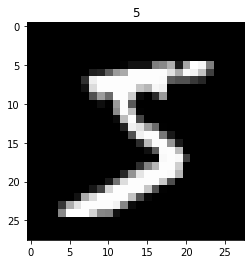

In [55]:
from __future__ import print_function
import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import matplotlib.pyplot as plt
from keras import backend as K

batch_size = 1
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print_index = 0
plt.imshow(np.reshape(x_train[print_index], (28, 28)), cmap='gray')  
plt.title('%i' % y_train[print_index])  
plt.show()

In [56]:
def float_to_hex(data, int_bit, point_bit, merge):
  hex_map = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F']

  int_part = data - data % 1 # 整數部分
  point_part = data % 1 # 小數部分
  bit_num = int_bit + point_bit # 總bit數
  bit_res = bit_num % 4 # 處理到最後剩餘bit數
  before_merge = ['' for data_num in range(len(data))] # 合併前結果

  for data_index in range(len(data)): # 將signed轉換成unsigned
    if int_part[data_index] < 0:
      int_part[data_index] += (2 ** int_bit)

  unsigned_fixed = int_part + point_part # unsigned fixed point
  for pow in range(int_bit, -point_bit - 1, -4):
    if pow != int_bit:
      unsigned_fixed = unsigned_fixed * (2 ** -pow)
      for data_index in range(len(unsigned_fixed)):
        before_merge[data_index] = before_merge[data_index] + hex_map[int(unsigned_fixed[data_index])]
      unsigned_fixed = (unsigned_fixed % 1) * (2 ** pow)
  if bit_res != 0: # 剩餘bit
    unsigned_fixed = (unsigned_fixed * (2 ** point_bit) - (unsigned_fixed * (2 ** point_bit) % 1)) * (2 ** (4 - bit_res))
    for data_index in range(len(unsigned_fixed)):
      before_merge[data_index] = before_merge[data_index] + hex_map[int(unsigned_fixed[data_index])]

  #print(before_merge)

  if len(data) % merge != 0:
    print('無法整除')
  else:
    result = ['' for data_num in range(int(len(data) / merge))] # Merge後結果

    head_index = 0 # 開頭位置
    now_index = 0 # 儲存在result的位置

    while now_index != len(result):
      for i in range(head_index, head_index + merge):
        result[now_index] += before_merge[i]
      head_index += merge
      now_index += 1

    return result


In [69]:
def Golden(image, kernel, num_kernel):

  Conv_weight = np.array(kernel[num_kernel])
  Conv_weight = Conv_weight - Conv_weight % (2 ** -5)
  row_kernel = np.array([]) # temp for every row output form Conv kernel 1
  '''To MaxPool'''
  Imageout_kernal = np.empty((0, 26), float) # Image output form kernal 1
  ################

  for col in range(0,26):
    for row in range(0,26):
      filter = 0
      for i in range(3):
        for j in range(3):
          tmp1 = image[col + i, row + j] * Conv_weight[3 * i + j]
          filter += tmp1
      if filter % (2 ** -5) >= (2 ** -6):
        filter += (2 ** -5)
      filter = max(filter, 0)
      row_kernel = np.append(row_kernel, filter)
    Imageout_kernal = np.append(Imageout_kernal, np.expand_dims(row_kernel, axis = 0), axis = 0)
    row_kernel = np.array([])

  #print(np.reshape((Imageout_kernal_1), 676))
  #print(np.reshape((Imageout_kernal_2), 676))
  
  result = float_to_hex(np.reshape((Imageout_kernal), 676), 3, 5, 4)
  print(result)
  output_file_name = 'test_' + '0' + '_kernel_' + str(num_kernel) + '_hex.txt'
  output_file = open(output_file_name, 'w')
  for data in result:
    output_file.write(data + '\n')
  output_file.close()

  '''for index in range(len(result1)):
      if np.reshape((Imageout_kernal_1), 676)[index] - np.reshape((Imageout_kernal_1), 676)[index] % (2 ** -5) != int(result1[index][0], 16) * (2 ** -1) + int(result1[index][1], 16) * (2 ** -5):
        print("hi1 : ", index)
        print( np.reshape((Imageout_kernal_1), 676)[index] - np.reshape((Imageout_kernal_1), 676)[index] % (2 ** -5), int(result1[index][0], 16) * (2 ** -1) + int(result1[index][1], 16) * (2 ** -5))
  for index in range(len(result2)):
      if np.reshape((Imageout_kernal_2), 676)[index] - np.reshape((Imageout_kernal_2), 676)[index] % (2 ** -5) != int(result2[index][0], 16) * (2 ** -1) + int(result2[index][1], 16) * (2 ** -5):
        print("hi2", index)
        print( np.reshape((Imageout_kernal_2), 676)[index] - np.reshape((Imageout_kernal_2), 676)[index] % (2 ** -5), int(result2[index][0], 16) * (2 ** -1) + int(result2[index][1], 16) * (2 ** -5))'''

In [68]:
# def Golden(image, kernel, num_kernel, num_layer):

#   Conv_weight = np.array(kernel[num_layer][num_kernel])
#   Conv_weight = Conv_weight - Conv_weight % (2 ** -5)
#   row_kernel = np.array([]) # temp for every row output form Conv kernel 1
#   '''To MaxPool'''
#   Imageout_kernal = np.empty((0, 26), float) # Image output form kernal 1
#   ################

#   for col in range(0,26):
#     for row in range(0,26):
#       filter = 0
#       for i in range(3):
#         for j in range(3):
#           tmp1 = image[col + i, row + j] * Conv_weight[3 * i + j]
#           filter += tmp1
#       if filter % (2 ** -5) >= (2 ** -6):
#         filter += (2 ** -5)
#       filter = max(filter, 0)
#       row_kernel = np.append(row_kernel, filter)
#     Imageout_kernal = np.append(Imageout_kernal, np.expand_dims(row_kernel, axis = 0), axis = 0)
#     row_kernel = np.array([])

#   #print(np.reshape((Imageout_kernal_1), 676))
#   #print(np.reshape((Imageout_kernal_2), 676))
  
#   result = float_to_hex(np.reshape((Imageout_kernal), 676), 3, 5, 4)
#   print(result)
#   output_file_name = 'test_' + str(num_layer) + '_kernel_' + str(num_kernel) + '_hex.txt'
#   output_file = open(output_file_name, 'w')
#   for data in result:
#     output_file.write(data + '\n')
#   output_file.close()

#   '''for index in range(len(result1)):
#       if np.reshape((Imageout_kernal_1), 676)[index] - np.reshape((Imageout_kernal_1), 676)[index] % (2 ** -5) != int(result1[index][0], 16) * (2 ** -1) + int(result1[index][1], 16) * (2 ** -5):
#         print("hi1 : ", index)
#         print( np.reshape((Imageout_kernal_1), 676)[index] - np.reshape((Imageout_kernal_1), 676)[index] % (2 ** -5), int(result1[index][0], 16) * (2 ** -1) + int(result1[index][1], 16) * (2 ** -5))
#   for index in range(len(result2)):
#       if np.reshape((Imageout_kernal_2), 676)[index] - np.reshape((Imageout_kernal_2), 676)[index] % (2 ** -5) != int(result2[index][0], 16) * (2 ** -1) + int(result2[index][1], 16) * (2 ** -5):
#         print("hi2", index)
#         print( np.reshape((Imageout_kernal_2), 676)[index] - np.reshape((Imageout_kernal_2), 676)[index] % (2 ** -5), int(result2[index][0], 16) * (2 ** -1) + int(result2[index][1], 16) * (2 ** -5))'''

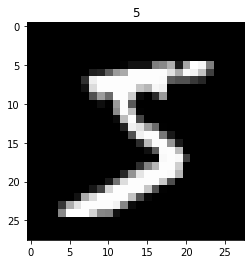

layer_0
['00000000', '00000000', '00000000', '00000000', '00000000', '00000000', '00000000', '00000000', '00000000', '00000000', '00000000', '00000000', '00000000', '00000000', '00000000', '00000000', '00000000', '00000000', '00000000', '00000000', '00000000', '00000000', '00000000', '00000001', '00000000', '00000000', '00000000', '00000000', '00000000', '00000000', '00000000', '00000007', '00000000', '00000000', '00000000', '00000000', '00000000', '00000000', '00000000', '00000000', '00000000', '00000000', '00000000', '00000000', '00000000', '00000000', '00000000', '00000000', '00000000', '00000300', '00000000', '00000000', '00000000', '00000000', '00000000', '00000000', '00000000', '00000000', '00000000', '00000000', '00000000', '00000500', '00000E00', '00000000', '00000000', '00000000', '00000000', '01000000', '00000000', '00000000', '00000000', '00000000', '00000000', '00000000', '00000000', '00000000', '00000000', '00000000', '00000000', '00000000', '00000000', '00000000', '000000

In [70]:
#print(x_train[print_index] - x_train[print_index] % (2 ** -5))
plt.imshow(np.reshape(x_train[print_index], (28, 28)), cmap='gray')
plt.title('%i' % y_train[print_index])  
plt.show()
print('layer_0')
for num_kernel in range(0, 32):
  Golden(np.reshape(x_train[num_kernel] - x_train[num_kernel] % (2 ** -5), (28, 28)), kernel_array, num_kernel)

In [ ]:
plt.imshow(np.reshape(x_train[print_index], (28, 28)), cmap='gray')
plt.title('%i' % y_train[print_index])  
plt.show()
for num_layer in range(0, 2):
  print('layer_' + str(num_layer))
  for num_kernel in range(0, 32):
    Golden(np.reshape(x_train[num_kernel] - x_train[num_kernel] % (2 ** -5), (28, 28)), kernel_array, num_kernel, num_layer)